In [2]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

from xgboost import plot_importance
import matplotlib.pyplot as plt

from utils.query_snowflake import SnowflakeConnector

import mlflow

C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\snowflake\connector\options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (19.0.1), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [3]:
sf = SnowflakeConnector()
person_df = sf.query("SELECT * FROM public.psam_p05")

✅ Connected to Snowflake


C:\Users\User\PycharmProjects\pums\utils\query_snowflake.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, self.ctx)


✅ Query executed: 146898 rows retrieved


In [4]:
sf = SnowflakeConnector()
housing_df = sf.query("SELECT * FROM public.psam_h05")

✅ Connected to Snowflake
✅ Query executed: 74947 rows retrieved


In [5]:
housing_df = housing_df[[col for col in housing_df.columns if col not in ['RT', 'PUMA10', 'PUMA20', 'DIVISION', 'REGION', 'ST', 'ADJINC']]]

In [6]:
df = person_df.merge(housing_df, on="SERIALNO", how="left")

In [7]:
df

,RT,SERIALNO,DIVISION,SPORDER,PUMA10,PUMA20,REGION,ST,ADJINC,PWGTP,...,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
0,P,2018GQ0000015,7,1,1000,-9,3,5,1184371,17,...,0,0,0,0,0,0,0,0,0,0
1,P,2018GQ0000018,7,1,200,-9,3,5,1184371,19,...,0,0,0,0,0,0,0,0,0,0
2,P,2018GQ0000044,7,1,200,-9,3,5,1184371,17,...,0,0,0,0,0,0,0,0,0,0
3,P,2018GQ0000200,7,1,1600,-9,3,5,1184371,18,...,0,0,0,0,0,0,0,0,0,0
4,P,2018GQ0000206,7,1,800,-9,3,5,1184371,17,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146893,P,2022HU1446440,7,2,-9,900,3,5,1042311,69,...,21,78,54,108,45,47,56,79,85,16
146894,P,2022HU1446440,7,3,-9,900,3,5,1042311,57,...,21,78,54,108,45,47,56,79,85,16
146895,P,2022HU1446444,7,1,-9,101,3,5,1042311,8,...,15,11,2,8,8,12,2,9,7,13
146896,P,2022HU1446444,7,2,-9,101,3,5,1042311,6,...,15,11,2,8,8,12,2,9,7,13


In [8]:
# Basic stats
summary = df.describe(include='all').transpose()

# Missing values
missing_count = df.isnull().sum()
missing_pct = (missing_count / len(df)) * 100
unique_vals = df.nunique()
dtypes = df.dtypes.astype(str)

# Combine
summary['missing_count'] = missing_count
summary['missing_pct'] = missing_pct
summary['unique'] = unique_vals
summary['dtype'] = dtypes

# Only round numeric stats
numeric_cols = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
for col in numeric_cols:
    if col in summary.columns:
        summary[col] = summary[col].round(4)

# Final formatting
summary = summary.reset_index().rename(columns={'index': 'column'})

# Save locally
summary.to_csv('eda_summary.csv', index=False)

In [9]:
# Upload
sf.upload(df=summary, table_name='EDA_SUMMARY', auto_create=True, overwrite=True)

✅ Uploaded 520 rows to EDA_SUMMARY


In [18]:
# 1. Define groups
income_fields = ["FINCP", "HINCP"] + ["INTP", "OIP", "PAP", "PERNP", "PINCP", "RETP", "SEMP", "SSIP", "SSP", "WAGP"]
housing_fields = ["ELEP", "CONP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", 
                  "WATP", "GRNTP", "SMOCP", "TAXAMT", "CONP",]

# 2. Adjust to 2022 dollars
for field in income_fields:
    df[field] = df[field] * df["ADJINC"] / 1_000_000

for field in housing_fields:
    df[field] = df[field] * df["ADJHSG"] / 1_000_000

In [19]:
allowed_codes = [
    '11','21','22','23','31','32','33','3M','42','44','45','48','49',
    '4M','51','52','53','54','55','56','61','62','71','72','81','92','99','na'
]

df['NAICSP_clean'] = df['NAICSP'].fillna('na').apply(
    lambda x: str(x)[:2] if str(x)[:2] in allowed_codes else 'na'
)

naicsp_dummies = pd.get_dummies(
    pd.Categorical(df['NAICSP_clean'], categories=allowed_codes),
    prefix='NAICSP'
)

# Step 3: Combine and drop original columns
df = pd.concat([df.drop(columns=['NAICSP', 'NAICSP_clean']), naicsp_dummies], axis=1)

In [20]:
allowed_socp_codes = [
    '11','13','15','17','19','21','23','25','27','29','31','33',
    '35','37','39','41','43','45','47','49','51','53','55','99','na'
]

# Step 1: Clean SOCP values to 2-digit prefix or 'na'
df['SOCP_clean'] = df['SOCP'].fillna('na').apply(
    lambda x: str(x)[:2] if str(x)[:2] in allowed_socp_codes else 'na'
)

# Step 2: One-hot encode with fixed categories
socp_dummies = pd.get_dummies(
    pd.Categorical(df['SOCP_clean'], categories=allowed_socp_codes),
    prefix='SOCP'
)

# Step 3: Drop original columns and combine
df = pd.concat([df.drop(columns=['SOCP', 'SOCP_clean']), socp_dummies], axis=1)


In [23]:
# Derived ratios
df["income_per_person"] = df["HINCP"] / (df["NP"].replace(0, np.nan))
df["income_per_room"] = df["HINCP"] / (df["RMSP"].replace(0, np.nan))
df["rent_to_income_ratio"] = df["RNTP"] / (df["HINCP"].replace(0, np.nan))

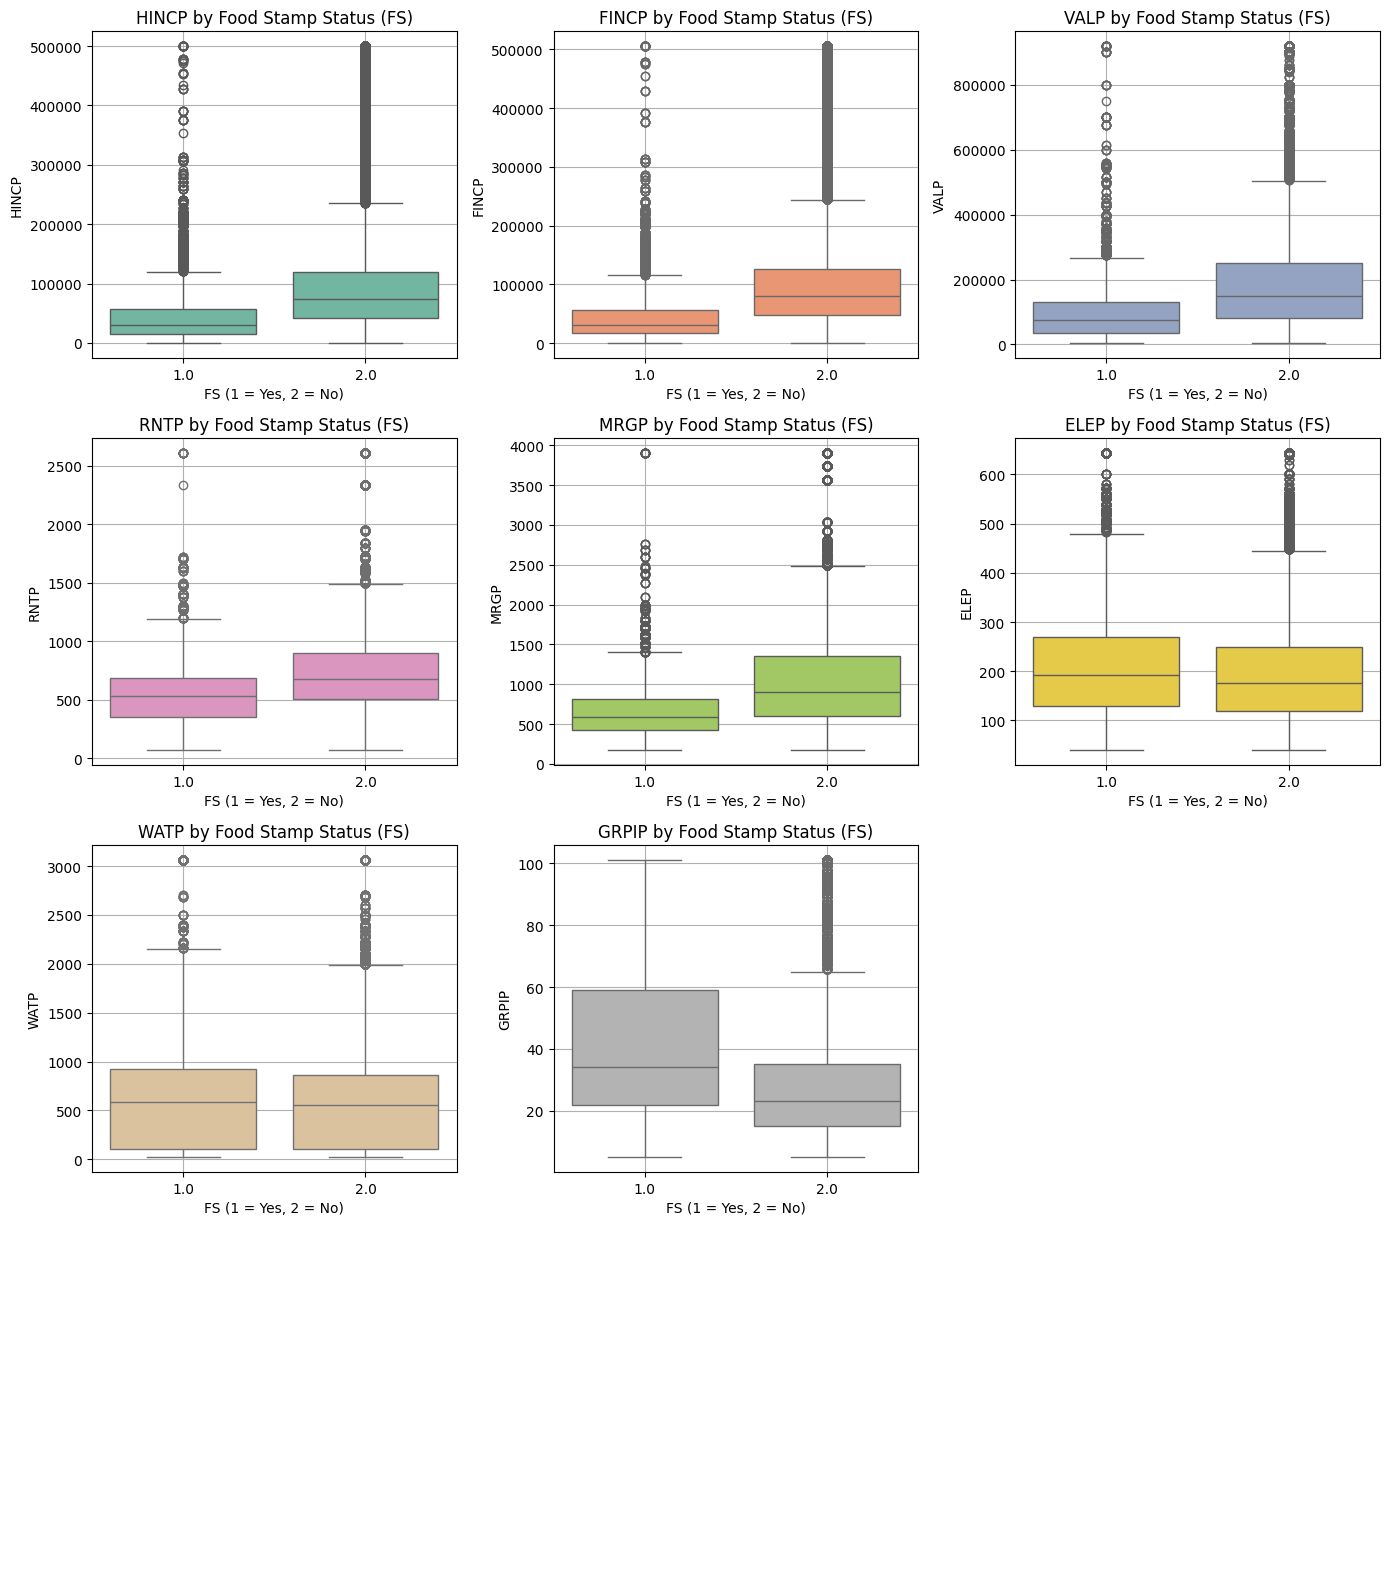

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selected columns
cols_to_plot = [
    'HINCP', 'FINCP', 'VALP', 'RNTP',
    'MRGP', 'ELEP', 'WATP', 'GRPIP', 'FS'
]

df_plot = df[cols_to_plot].copy()

# Outlier clipping
for col in cols_to_plot[:-1]:  # Exclude FS
    q_low = df_plot[col].quantile(0.01)
    q_hi = df_plot[col].quantile(0.99)
    df_plot[col] = df_plot[col].clip(lower=q_low, upper=q_hi)

# Set up 4x2 grid
fig, axes = plt.subplots(4, 3, figsize=(14, 16))
axes = axes.flatten()
colors = sns.color_palette("Set2", len(cols_to_plot) - 1)

# Plot each variable
for i, var in enumerate(cols_to_plot[:-1]):
    sns.boxplot(
        x='FS',
        y=var,
        hue='FS',
        data=df_plot,
        ax=axes[i],
        palette=[colors[i]]*2,
        legend=False
    )
    axes[i].set_title(f'{var} by Food Stamp Status (FS)')
    axes[i].set_xlabel('FS (1 = Yes, 2 = No)')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(len(cols_to_plot) - 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [3]:
df["FS"].value_counts(normalize=True)  # Class balance: 1 = received, 2 = not
df.info()                              # Check missing columns
df.describe(include='all')             # Look for skewed/distinct values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74947 entries, 0 to 74946
Columns: 238 entries, RT to WGTP80
dtypes: float64(145), int64(91), object(2)
memory usage: 136.1+ MB


,RT,SERIALNO,DIVISION,PUMA10,PUMA20,REGION,ST,ADJHSG,ADJINC,WGTP,...,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
count,74947,74947,74947.0,74947.000000,74947.000000,74947.0,74947.0,7.494700e+04,7.494700e+04,74947.000000,...,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000,74947.000000
unique,1,74947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,H,2022HU1446444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,74947,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,7.0,766.965135,189.394532,3.0,5.0,1.104757e+06,1.127042e+06,18.302387,...,18.299492,18.297450,18.301480,18.301760,18.301039,18.299718,18.299291,18.301053,18.300572,18.301920
std,NaN,NaN,0.0,658.816700,449.824002,0.0,0.0,6.179373e+04,4.985358e+04,20.905233,...,24.189752,24.389048,24.287775,24.495508,24.125997,24.277673,24.256346,24.361174,24.188030,24.373449
min,NaN,NaN,7.0,-9.000000,-9.000000,3.0,5.0,1.000000e+06,1.042311e+06,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,7.0,100.000000,-9.000000,3.0,5.0,1.080912e+06,1.113261e+06,5.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,NaN,NaN,7.0,700.000000,-9.000000,3.0,5.0,1.133141e+06,1.140108e+06,13.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,NaN,NaN,7.0,1300.000000,-9.000000,3.0,5.0,1.148217e+06,1.159866e+06,23.000000,...,24.000000,24.000000,24.000000,24.000000,23.000000,24.000000,23.000000,23.000000,23.000000,24.000000


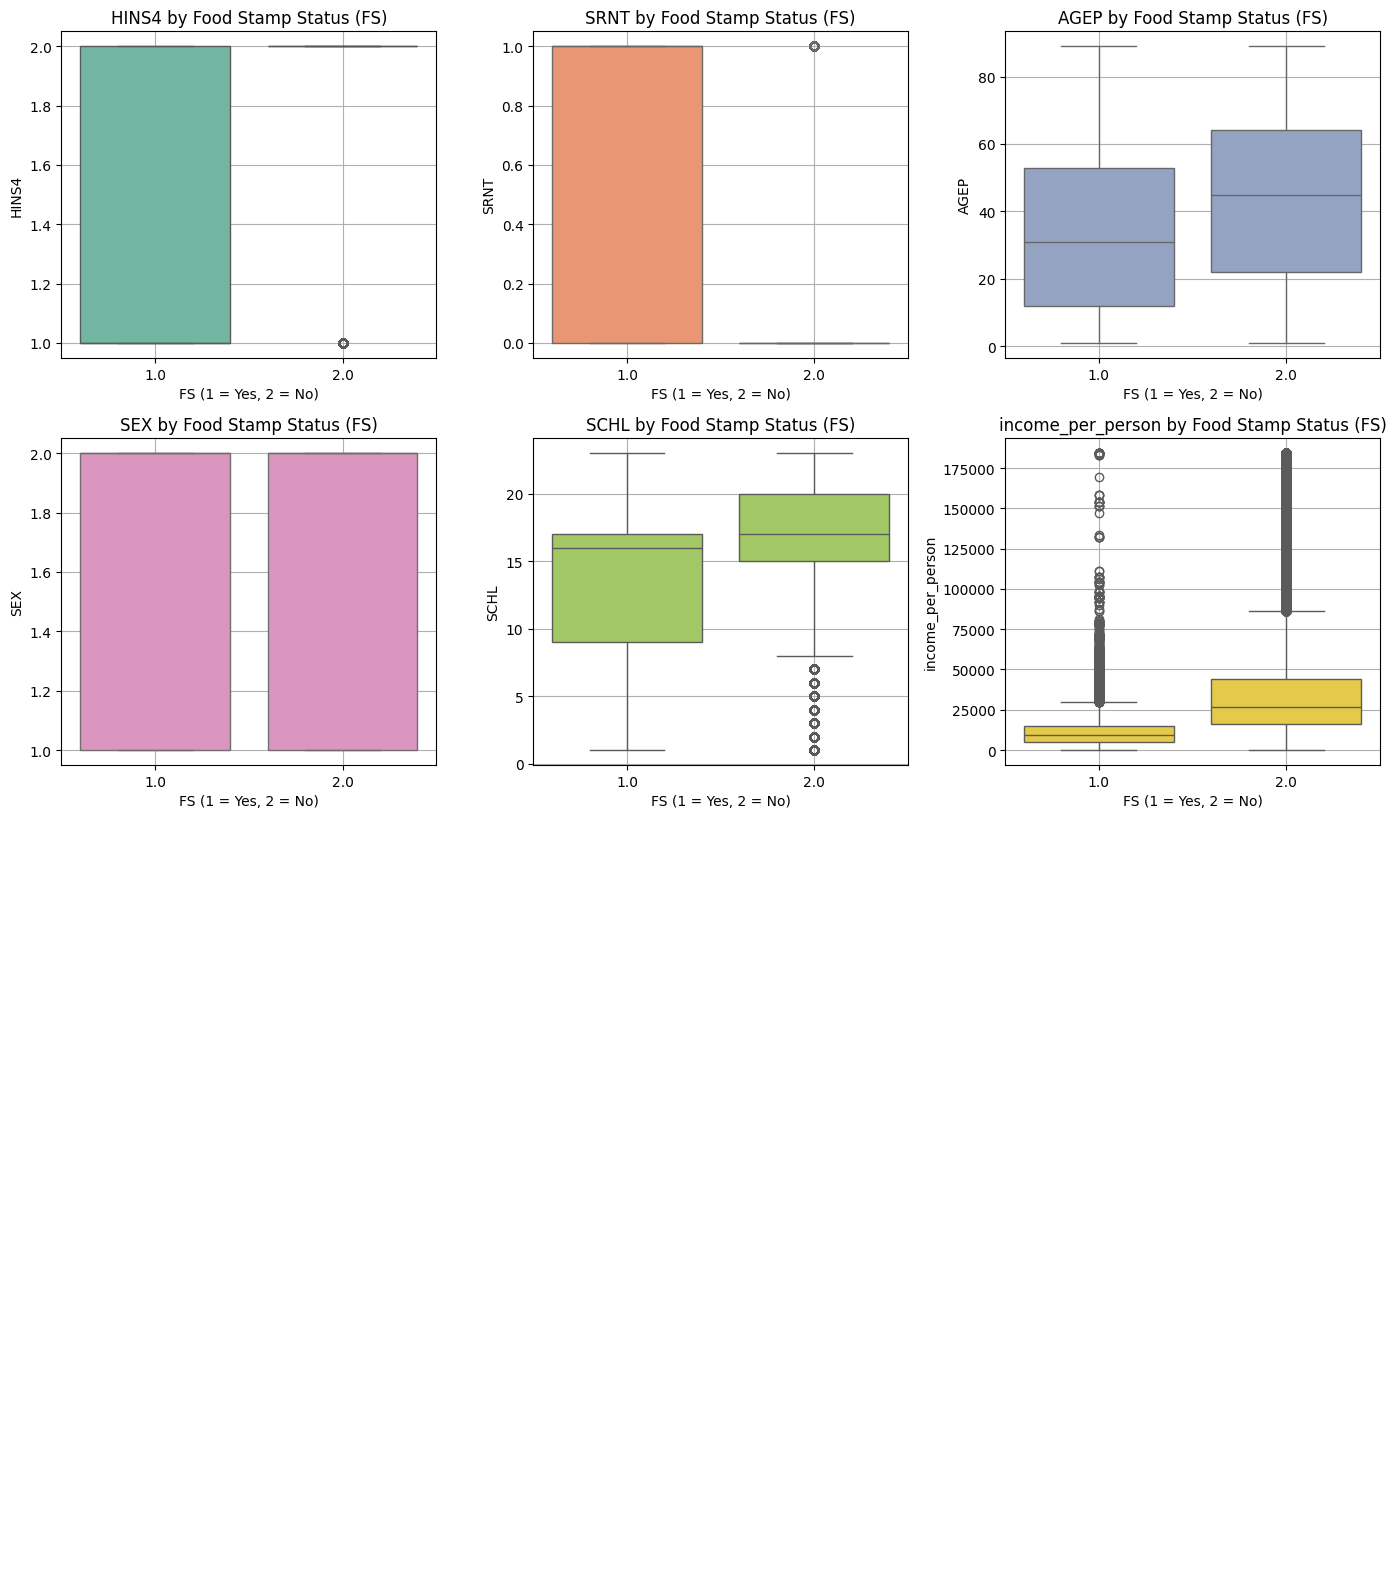

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selected columns
cols_to_plot = [
    'HINS4', 'SRNT', 'AGEP', 'SEX', 'SCHL', 'income_per_person', 'FS'
]

df_plot = df[cols_to_plot].copy()

# Outlier clipping
for col in cols_to_plot[:-1]:  # Exclude FS
    q_low = df_plot[col].quantile(0.01)
    q_hi = df_plot[col].quantile(0.99)
    df_plot[col] = df_plot[col].clip(lower=q_low, upper=q_hi)

# Set up 4x2 grid
fig, axes = plt.subplots(4, 3, figsize=(14, 16))
axes = axes.flatten()
colors = sns.color_palette("Set2", len(cols_to_plot) - 1)

# Plot each variable
for i, var in enumerate(cols_to_plot[:-1]):
    sns.boxplot(
        x='FS',
        y=var,
        hue='FS',
        data=df_plot,
        ax=axes[i],
        palette=[colors[i]]*2,
        legend=False
    )
    axes[i].set_title(f'{var} by Food Stamp Status (FS)')
    axes[i].set_xlabel('FS (1 = Yes, 2 = No)')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(len(cols_to_plot) - 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


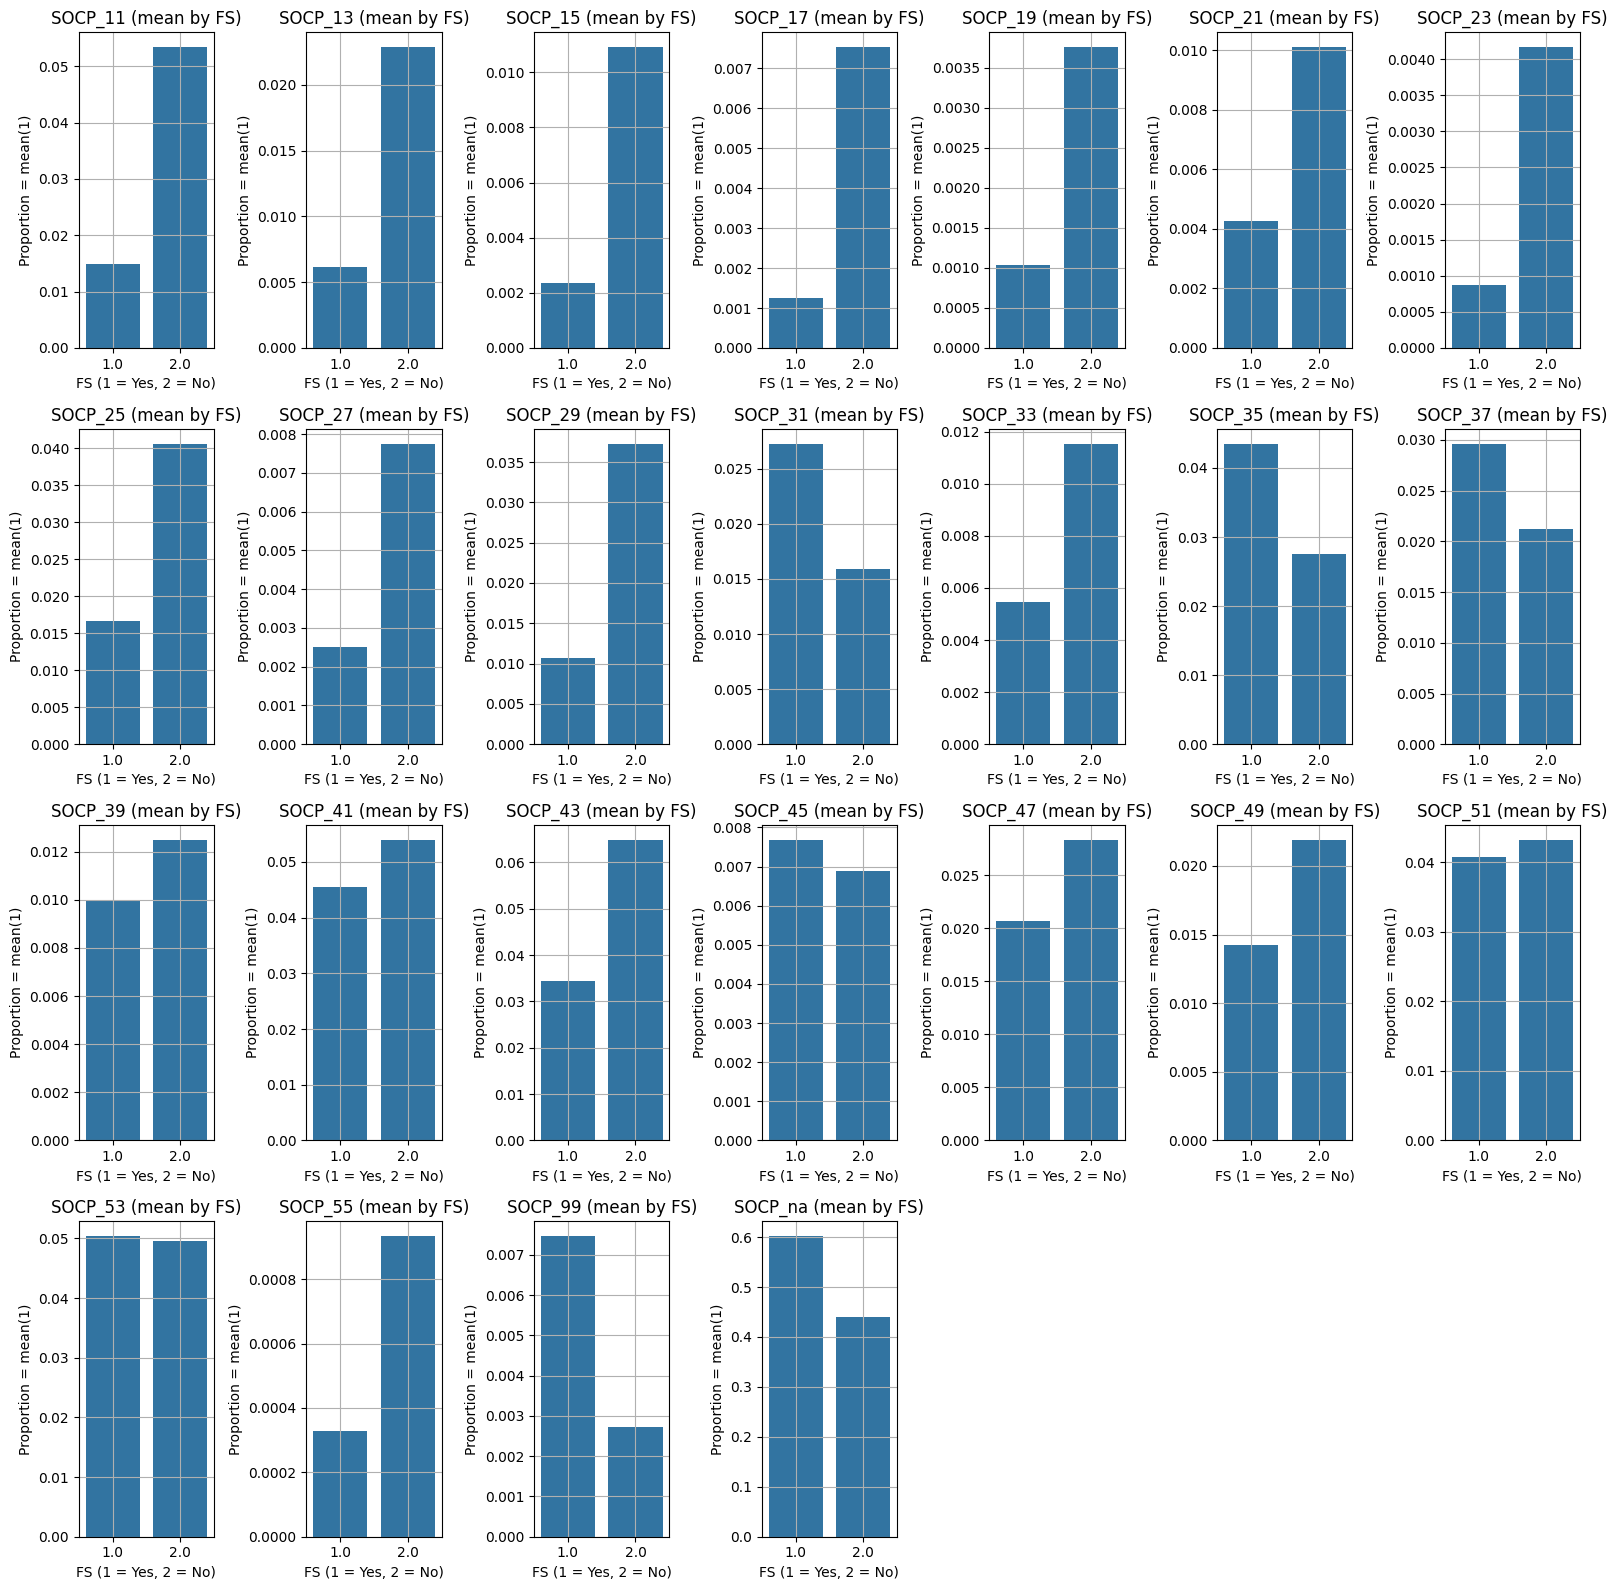

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter your binary SOCP_X columns
socp_cols = [col for col in df.columns if col.startswith("SOCP_")]
fs_col = "FS"

# Set up a 4x4 grid (adjust based on number of columns)
n_cols = 7
n_rows = -(-len(socp_cols) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

# Plot proportion of 1s for each SOCP_X column by FS status
for i, col in enumerate(socp_cols):
    prop_df = df.groupby(fs_col)[col].mean().reset_index()
    sns.barplot(x=fs_col, y=col, data=prop_df, ax=axes[i])
    axes[i].set_title(f"{col} (mean by FS)")
    # axes[i].set_ylim(0, 1)
    axes[i].set_xlabel("FS (1 = Yes, 2 = No)")
    axes[i].set_ylabel("Proportion = mean(1)")
    axes[i].grid(True)

# Hide any unused subplots
for j in range(len(socp_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


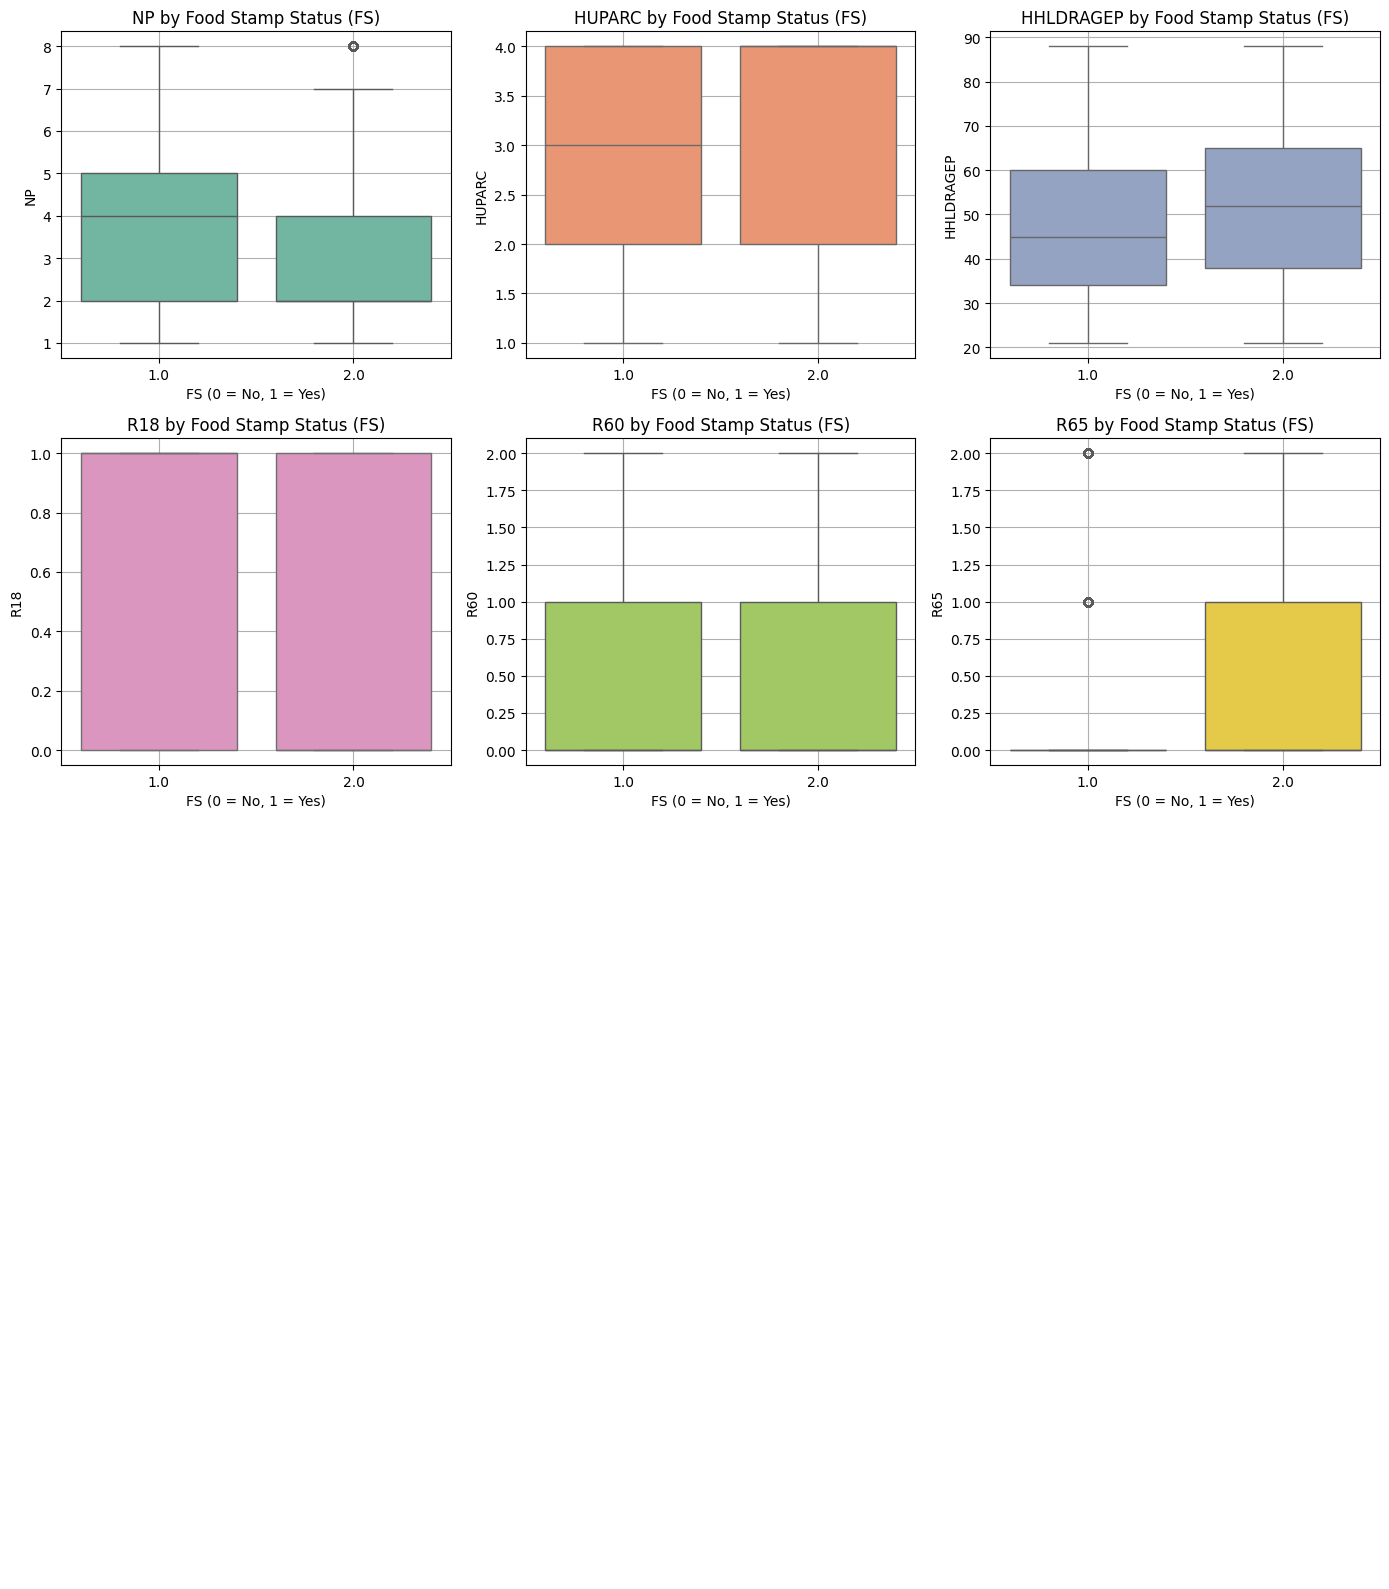

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selected columns
cols_to_plot = [
    'NP', 'HUPARC', 'HHLDRAGEP',
    'R18', 'R60', 'R65'
    , 'FS'
]

df_plot = df[cols_to_plot].copy()

# Outlier clipping
for col in cols_to_plot[:-1]:  # Exclude FS
    q_low = df_plot[col].quantile(0.01)
    q_hi = df_plot[col].quantile(0.99)
    df_plot[col] = df_plot[col].clip(lower=q_low, upper=q_hi)

# Set up 4x2 grid
fig, axes = plt.subplots(4, 3, figsize=(14, 16))
axes = axes.flatten()
colors = sns.color_palette("Set2", len(cols_to_plot) - 1)

# Plot each variable
for i, var in enumerate(cols_to_plot[:-1]):
    sns.boxplot(
        x='FS',
        y=var,
        hue='FS',
        data=df_plot,
        ax=axes[i],
        palette=[colors[i]]*2,
        legend=False
    )
    axes[i].set_title(f'{var} by Food Stamp Status (FS)')
    axes[i].set_xlabel('FS (0 = No, 1 = Yes)')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(len(cols_to_plot) - 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [40]:
df["age_group"] = pd.cut(
    df["HHLDRAGEP"],
    bins=[0, 30, 45, 60, 75, 120],
    labels=["young", "mid_young", "middle", "senior", "elderly"]
)

In [44]:
fs_rate

,age_group,FS
0,young,1.868434
1,mid_young,1.857155
2,middle,1.880674
3,senior,1.908444
4,elderly,1.932662


C:\Users\User\AppData\Local\Temp\ipykernel_5852\2661984949.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fs_rate = df.groupby("age_group")["FS"].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_5852\2661984949.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fs_rate, x="age_group", y="FS", palette="Blues_d")


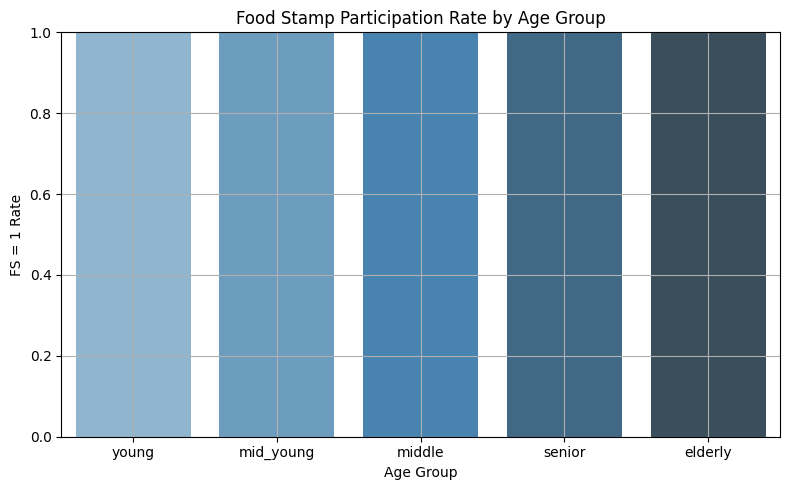

In [43]:
fs_rate = df.groupby("age_group")["FS"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=fs_rate, x="age_group", y="FS", palette="Blues_d")
plt.title("Food Stamp Participation Rate by Age Group")
plt.ylabel("FS = 1 Rate")
plt.xlabel("Age Group")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selected columns
cols_to_plot = [
    'NP', 'HUPARC', 'HHLDRAGEP',
    'R18', 'R60', 'R65'
    , 'FS'
]

df_plot = df[cols_to_plot].copy()

# Outlier clipping
for col in cols_to_plot[:-1]:  # Exclude FS
    q_low = df_plot[col].quantile(0.01)
    q_hi = df_plot[col].quantile(0.99)
    df_plot[col] = df_plot[col].clip(lower=q_low, upper=q_hi)

# Set up 4x2 grid
fig, axes = plt.subplots(4, 3, figsize=(14, 16))
axes = axes.flatten()
colors = sns.color_palette("Set2", len(cols_to_plot) - 1)

# Plot each variable
for i, var in enumerate(cols_to_plot[:-1]):
    sns.boxplot(
        x='FS',
        y=var,
        hue='FS',
        data=df_plot,
        ax=axes[i],
        palette=[colors[i]]*2,
        legend=False
    )
    axes[i].set_title(f'{var} by Food Stamp Status (FS)')
    axes[i].set_xlabel('FS (0 = No, 1 = Yes)')
    axes[i].grid(True)

# Hide any unused subplots
for j in range(len(cols_to_plot) - 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [110]:
missing_ratio = df.isna().mean()
high_missing_ratio = df.loc[:, missing_ratio >= 0.95].columns.tolist()

In [111]:
# 1. Define groups
income_fields = ["FINCP", "HINCP",]
housing_fields = ["ELEP", "CONP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", 
                  "WATP", "GRNTP", "SMOCP", "TAXAMT", "CONP",]

# 2. Adjust to 2022 dollars
for field in income_fields:
    df[field] = df[field] * df["ADJINC"] / 1_000_000

for field in housing_fields:
    df[field] = df[field] * df["ADJHSG"] / 1_000_000

# Derived ratios
df["income_per_person"] = df["HINCP"] / (df["NP"].replace(0, np.nan))
df["income_per_room"] = df["HINCP"] / (df["RMSP"].replace(0, np.nan))
df["rent_to_income_ratio"] = df["RNTP"] / (df["HINCP"].replace(0, np.nan))



# 6. Count imputed features
alloc_cols = [col for col in df.columns if col.startswith("F") and col.endswith("P")]
df["num_imputed_features"] = df[alloc_cols].eq(1).sum(axis=1)

In [112]:
def map_cplt(val):
    if val in [1, 2]:
        return "Spouse_Household"
    elif val in [3, 4]:
        return "Partner_Household"
    else:
        return "Not_Couple"

df["CPLT_group"] = df["CPLT"].replace("b", np.nan).astype(float).apply(map_cplt)


def map_wkexrel(val):
    if val in [1, 2, 4, 5]:
        return "Both_Worked"
    elif val in [3, 6]:
        return "Householder_Worked_Only"
    elif val in [7, 8]:
        return "Spouse_Worked_Only"
    elif val == 9:
        return "Neither_Worked"
    elif val in [10, 13]:
        return "Householder_Alone_FT"
    elif val in [11, 14]:
        return "Householder_Alone_Part"
    elif val in [12, 15]:
        return "Householder_Alone_None"
    else:
        return "No_Family"


df["WKEXREL_group"] = df["WKEXREL"].replace("bb", np.nan).apply(map_wkexrel)

df = pd.get_dummies(df, columns=["CPLT_group", "WKEXREL_group"], dtype=int)

df.drop(columns=["CPLT", "WKEXREL"], inplace=True)

In [113]:
# # 1. Household Composition
# df["is_single_person"] = (df["NP"] == 1).astype(int)
# df["is_large_household"] = (df["NP"] >= 5).astype(int)
# df["room_per_person"] = df["RMSP"] / df["NP"].replace(0, np.nan)
# df["bathroom_to_bedroom_ratio"] = df["FBATHP"] / df["BDSP"].replace(0, np.nan)

# # 2. Affordability Indicators
# df["housing_cost_ratio"] = (
#     df["GRNTP"].fillna(df["SMOCP"]).fillna(df["RNTP"]) / df["HINCP"].replace(0, np.nan)
# )
# df["mortgage_or_rent_flag"] = ((df["MRGP"] > 0) | (df["RNTP"] > 0)).astype(int)
# df["owns_home_flag"] = df["TEN"].isin([1, 2]).astype(int)

# # 3. Technology Access
# df["has_internet"] = (df["HISPEED"] == 1).astype(int)
# df["num_devices"] = df[["SMARTPHONE", "TABLET", "LAPTOP"]].eq(1).sum(axis=1)
# df["tech_deprived_flag"] = ((df["num_devices"] == 0) & (df["has_internet"] == 0)).astype(int)

# # 4. Transportation
# df["no_vehicle_flag"] = (df["VEH"] == 0).astype(int)

# # 5. Top-coded Property Flag
# df["valp_topcoded"] = (df["VALP"] >= 1000000).astype(int)  # You can adjust threshold
# df["Is_Hispanic"] = df["HHLDRHISP"].map({1: 1, 2: 0})

# # 6. Missingness / Imputation
# alloc_cols = [col for col in df.columns if col.startswith("F") and col.endswith("P")]
# df["num_imputed_features"] = df[alloc_cols].eq(1).sum(axis=1)
# df["any_imputed_flag"] = (df["num_imputed_features"] > 0).astype(int)

# # 7. Property Value Buckets
# df["VALP_bucket"] = pd.cut(
#     df["VALP"],
#     bins=[-1, 100000, 300000, np.inf],
#     labels=["low", "mid", "high"]
# )
# df = pd.get_dummies(df, columns=["VALP_bucket"], prefix="VALP", dtype=int)
# df.drop(columns=["VALP"], inplace=True)

# # 8. Combine Room + Household Size into Crowding Score
# df["crowding_score"] = df["NP"] / df["RMSP"].replace(0, np.nan)
# df["is_crowded"] = (df["crowding_score"] > 1).astype(int)

# # 9. Utility burden
# df["num_utilities_paid"] = df[["WATP", "ELEP", "GASP", "INSP"]].gt(0).sum(axis=1)
# df["pays_all_utilities"] = (df["num_utilities_paid"] == 4).astype(int)

# 10. Age group
df["age_group"] = pd.cut(
    df["HHLDRAGEP"],
    bins=[0, 30, 45, 60, 75, 120],
    labels=["young", "mid_young", "middle", "senior", "elderly"]
)

df["age_x_income"] = df["HHLDRAGEP"] * df["HINCP"]



df = pd.get_dummies(df, columns=["age_group"], prefix="age")

In [141]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'WGTP', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)] + high_missing_ratio
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]

print(len(features))

# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))


249


C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6040
           1       0.72      0.38      0.50       703

    accuracy                           0.92      6743
   macro avg       0.83      0.68      0.73      6743
weighted avg       0.91      0.92      0.91      6743



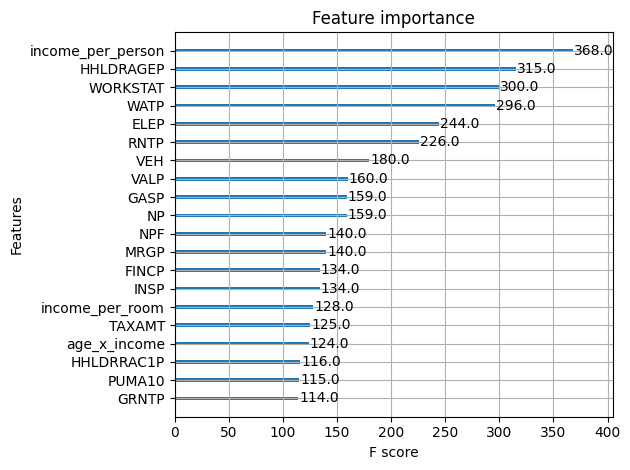

In [142]:
plot_importance(model, max_num_features=20)
plt.tight_layout()
plt.show()

In [143]:
booster = model.get_booster()
scores = booster.get_score()
importance_df = pd.DataFrame(scores.items(), columns=['feature', 'importance'])
filtered_features = importance_df.sort_values(by='importance', ascending=False).head(150)

In [144]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'WGTP', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)] + high_missing_ratio
features = [col for col in df.columns if col not in excluded]
X = df[filtered_features.feature.tolist()]
y = df["FS"]

print(len(features))

# Split and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))


249


C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6040
           1       0.71      0.38      0.49       703

    accuracy                           0.92      6743
   macro avg       0.82      0.68      0.73      6743
weighted avg       0.91      0.92      0.91      6743



## Imputer experiment

In [74]:
import miceforest as mf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


excluded = ['FS', 'RT', 'SERIALNO', 'WGTP', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)] + high_missing_ratio
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]

kernel = mf.ImputationKernel(df[features + ['FS']], random_state=42)
kernel.mice(1)
df_imputed = kernel.complete_data(0)

# Step 3: Split into features/target after imputation
X_imputed = df_imputed.drop(columns=["FS"])
y_imputed = df_imputed["FS"]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y_imputed, test_size=0.1, random_state=42
)

# Step 5: Train and evaluate XGBoost
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6040
           1       0.69      0.36      0.47       703

    accuracy                           0.92      6743
   macro avg       0.81      0.67      0.71      6743
weighted avg       0.90      0.92      0.90      6743



In [90]:
# Define features, excluding FS (target), RT, SERIALNO, and WGTP
excluded = ['FS', 'RT', 'SERIALNO', 'ADJINC', 'ADJHSG'] + ['WGPT' + str(i) for i in range(1, 81, 1)]
features = [col for col in df.columns if col not in excluded]
X = df[features]
y = df["FS"]
sample_weights = df["WGTP"]

# Step 2: Split data
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

# Step 3: Train with weights
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=w_train)
print(classification_report(y_test, model.predict(X_test)))

C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [01:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12103
           1       0.58      0.32      0.41      1382

    accuracy                           0.91     13485
   macro avg       0.76      0.65      0.68     13485
weighted avg       0.89      0.91      0.89     13485



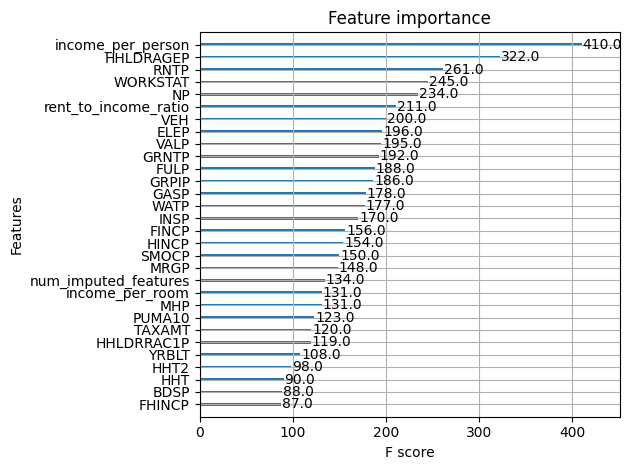

In [78]:
plot_importance(model, max_num_features=30)
plt.tight_layout()
plt.show()

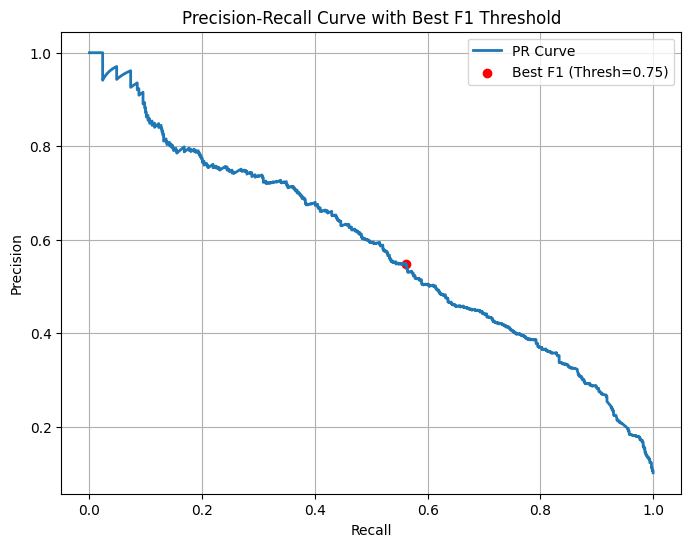

Best threshold: 0.75
F1 at best threshold: 0.555


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get predicted probabilities (class 1 = received FS)
y_proba = model.predict_proba(X_test)[:, 1]

# Get precision-recall values for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 scores for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Plot the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Best F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the best F1 threshold and value
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")
